# Catalytic Methanation Calc Sheet

In [4]:
#import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import fsolve
import seaborn as sns

## Reaction details

Reaction:

$CO_2 + 4 H_2 = CH_4 +2 H_2O$

Five moles of stoichiometric inflow results in 3 moles of out flow when the reaction goes to completion thus:

$n_{out} = n_{in}^s\cdot\left(1-2/5\cdot X_a\right) + n_{inert}$ 

where $X_a$ is the conversion defined as ($n_{in}^{CO2} - n_{out}^{CO2})/n_{in}^{CO2}$ and $s$ is the stoichiometric amount. Sometimes there are "inert" or excess gases that should also be treated as inert, we'll introduce a variable called $f_{inert}$ which is the fraction of gases that are inert and therfor $n_{inert} = f_{inert}\cdot n_{in}$. In the below treatment, I've calculated the fraction of inerts based on the above stoichiometric reaction.

Species molar flow balances:
\begin{equation}
n_{in}^{CH4} = n_{out}^{CH4} - r_W \\
n_{in}^{H2} = n_{out}^{H2} + 4\cdot r_W \\
n_{in}^{CO2} = n_{out}^{CO2} + r_W \\
n_{in}^{H2O} = n_{out}^{H2O} - 2\cdot r_W \\
n_{in}^{inert} = n_{out}^{inert} \\
---------- \\
n_{in} = n_{out} + 2\cdot r_W 
\end{equation}

Now substituting the above for $n_{out}$:<br>
\begin{equation}
n_{in} = n_{in}^s\cdot \left(1-2/5\cdot X_a\right) + n_{inert} + 2\cdot r_W \\
n_{in}^s = \left(1-f_{inert}\right)\cdot n_{in} \\
n_{in} = n_{in}\cdot \left(1-f_{inert}\right)\left(1-2/5\cdot X_a\right) + f_{inert}\cdot n_{in} + 2\cdot r_W \\
1 - \left(1-f_{inert}\right)\left(1-2/5\cdot X_a\right) - f_{inert}= 2\cdot r_W/n_{in}
\end{equation} <br>
The last equation relates the conversion to the reaction rate (weight based).

## Bartholomew Paper Summary

In [5]:
sitesperkg = 2*100E-3 #moles/kg of catalyst as reported as 100 micromoles uptake of H2 per gram
massB = 0.3e-3 #kg, they used 0.3 grams or about 1cc of catalyst
density = 300 #kg/m3 per the paper where 1 cc is about 0.3 grams
#space velocity is presumably the ratio of the flow rate at standard conditions to the catalyst volume
GHSV = 30000/60 #min^-1 low of paper value of 30,000 to 90,000 hr^-1
flowratesccmB = GHSV*1 #sccm
pressureB = 140000 #Pa
tempB = 525 #K
Rg = 8.314 #J/mol/K
#Turnover is the moles per moles of sites per second that are converted
CH4TON_1 = np.array([1.6,1.9,2.15,2.3,2.45,2.58,2.6,2.8])*1E-3 #at 252C, 140kPa total pressure, 1.4kPa CO2, balance Nitrogen
H2P_1=np.array([2.7,4.1,5.5,6.8,8.1,9.6,10.6,13.8]) #in kPa
stoichamt_1 = np.array([min(each/4,1.4)*5 for each in H2P_1])
fin_1 = (140 - stoichamt_1)/140
CH4TON_2 = np.array([1.53,1.7,1.85,2.04,2.05,2.17,2.3,2.35,2.47])*1E-3 #at 252C, 140kPa total, 5.62kPa H2, balance N2
CO2P_2 = np.array([0.25,0.45,0.55,0.8,1,1.35,1.6,2.1,2.75]) #in kPa
stoichamt_2 = np.array([min(each,5.6/4)*5 for each in CO2P_2])
fin_2 = (140 - stoichamt_2)/140


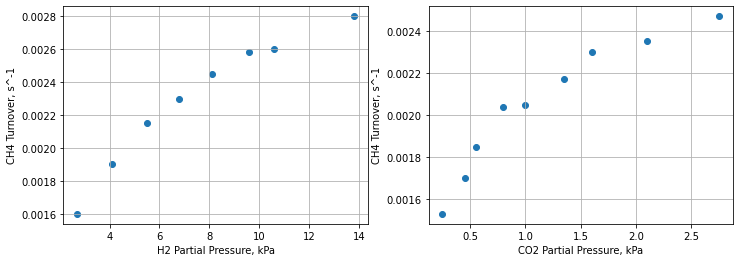

In [6]:
#Reproduction (estimate) of Fig. 1 and 2 from the paper
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
#fig.suptitle('Horizontally stacked subplots')
ax1.scatter(H2P_1,CH4TON_1)
ax2.scatter(CO2P_2,CH4TON_2)
ax1.set(xlabel='H2 Partial Pressure, kPa')
ax1.set(ylabel='CH4 Turnover, s^-1')
ax2.set(xlabel='CO2 Partial Pressure, kPa')
ax2.set(ylabel='CH4 Turnover, s^-1')
ax1.grid()
ax2.grid()
plt.show()

### Turnover to Reaction Rate

In [7]:
ninB = flowratesccmB/(60*1e6)*(101325)/(Rg*(298)) #moles per second

In [8]:
flowratesccmB

500.0

In [9]:
rateB_1 = CH4TON_1*sitesperkg #molCH4/kg/s
convB_1 = ((2*rateB_1/ninB*massB - 1 + fin_1)/(1-fin_1)+1)*2.5 #mol/s/kg

In [10]:
rateB_2 = CH4TON_2*sitesperkg #molCH4/kg/s
convB_2 = ((2*rateB_2/ninB*massB - 1 + fin_2)/(1-fin_2)+1)*2.5 #mol/s/kg

In [11]:
dd = {'rate(mol/kg/s)':np.append(rateB_1,rateB_2),'P_H2(kPa)':np.append(H2P_1,np.ones(9)*5.6),
      'P_CO2(kPa)':np.append(np.ones(8)*1.4,CO2P_2),'T(K)':np.ones(17)*525,'Ptot(kPa)':np.ones(17)*140,
      'source':['data']*17,'Conv':np.append(convB_1,convB_2),'fin':np.append(fin_1,fin_2)}

In [12]:
df1 = pd.DataFrame(dd)

In [13]:
df1['predicted']=1.56e5*np.exp(-89000/Rg/df1['T(K)'])*df1['P_H2(kPa)']**0.35*df1['P_CO2(kPa)']**0.2
df1['SE']=(df1['predicted']-df1['rate(mol/kg/s)'])**2

In [14]:
df2 = df1.copy()
df2['source'] = 'power'
df2['rate(mol/kg/s)']=df1['predicted']
df2['Conv'] = ((2*df2['rate(mol/kg/s)']/ninB*massB - 1 + df2['fin'])/(1-df2['fin'])+1)*2.5
df=pd.concat([df1,df2])
df['rate to Xa ratio']=df['rate(mol/kg/s)']/df['Conv']

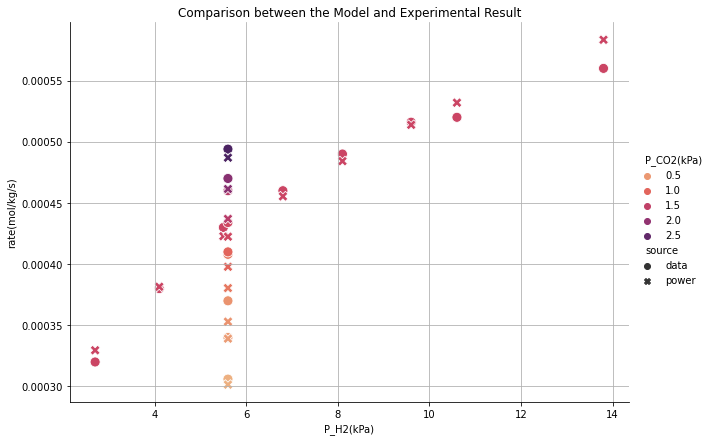

In [15]:
a = sns.relplot(data=df,x='P_H2(kPa)',y='rate(mol/kg/s)',hue='P_CO2(kPa)',
                s=100,style='source', palette='flare',aspect=12/8,height=6)
#a.axes[0,0].set_ylim(0,40); 
a.set(title='Comparison between the Model and Experimental Result')
plt.grid()
plt.show()

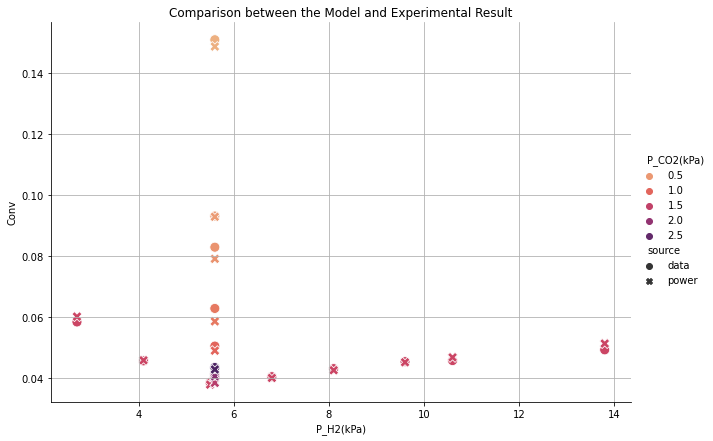

In [16]:
a = sns.relplot(data=df,x='P_H2(kPa)',y='Conv',hue='P_CO2(kPa)',
                s=100,style='source', palette='flare',aspect=12/8,height=6)
#a.axes[0,0].set_ylim(0,40); 
a.set(title='Comparison between the Model and Experimental Result')
plt.grid()
plt.show()

## UO Lab Data and Regression

In [17]:
dfdd = pd.read_csv('Library/CloudStorage/Box-Box/ChemE-CGuymon/TIPICE/UO Lab/Catalytic Methanation Experiment/Example Data/CatMethData(halfgram).csv')

In [18]:
dfd = dfdd[dfdd['GC']==2].copy()

Data taken in the UO lab in November 2022 on both systems. All at 200 sccm.

In [19]:
flow = 200/1e6*101325/(Rg*298)/60 #200 sccm total to mol/sec
catweight = 0.0005 # catalyst weight in kg (0.5 grams)
totalpressure = 124.106 #18 psia to kPa

In [20]:
dfd['Xa-CO2'] = 1-dfd['CO2, out']/dfd['CO2, in']
dfd['Xa-CO2'] = dfd.apply(lambda x: x['Xa-CO2'] if x['Xa-CO2']>0 else 0,axis=1)
dfd['Xa-CH4'] = dfd['CH4, out']/dfd['CO2, in']

In [21]:
dfd['finert'] = dfd.apply(lambda x: 1-min(x['H2, in']*5/4,x['CO2, in']*5), axis=1)

In [22]:
dfd['rate, mol/kg/s'] = (1-(1-dfd['finert'])*(1-2/5*dfd['Xa-CH4'])-dfd['finert'])*flow/2/catweight

In [23]:
dfd['T, K']=dfd['T, C']+273
dfd['source'] = 'data'

In [24]:
def power(x):
    stoichamtH2 = 4*dfd['CO2, in']
    return x[0]*np.exp(-x[1]/Rg/dfd['T, K'])*(dfd['H2, in']*totalpressure)**x[2]*(dfd['CO2, in']*totalpressure)**x[3] 

In [25]:
def func(x,*input):
    dfd['predicted']= power(x)
    return ((dfd['predicted']-dfd['rate, mol/kg/s'])**2).sum()

In [26]:
res = minimize(func,[3E3,90000,0.3,0.2,],method='Nelder-Mead')

In [27]:
#Minimized SSE
func(res.x)

2.2823681180505848e-07

In [28]:
dfd2 = dfd.copy()
dfd2['source'] = 'power'
dfd2['rate, mol/kg/s']=dfd['predicted']
dfd2['Xa-CH4'] = ((2*dfd2['rate, mol/kg/s']/flow*catweight - 1 + dfd2['finert'])/(1-dfd2['finert'])+1)*2.5
dfd2['Xa-CO2'] = ((2*dfd2['rate, mol/kg/s']/flow*catweight - 1 + dfd2['finert'])/(1-dfd2['finert'])+1)*2.5
dff=pd.concat([dfd,dfd2])
# Note that some of the columns that are labeled predicted should be removed like Xa or be recalculated

In [29]:
dff['P_H2(kPa)'] = totalpressure*dff['H2, in']; dff['P_CO2(kPa)'] = totalpressure*dff['CO2, in'];

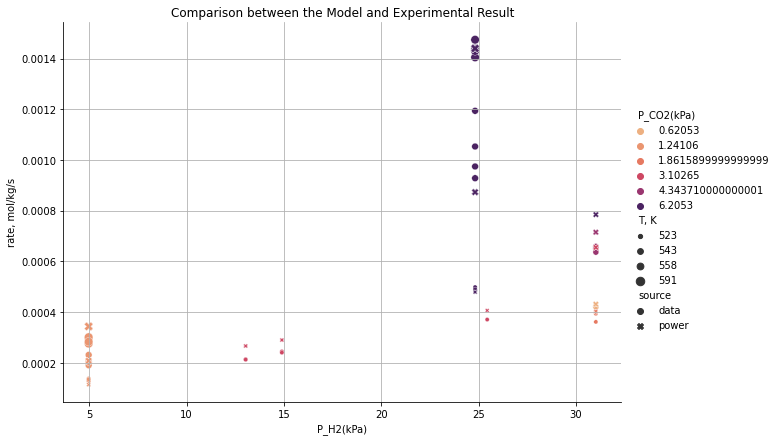

In [30]:
a = sns.relplot(data=dff,x='P_H2(kPa)',y='rate, mol/kg/s',hue='P_CO2(kPa)',
                size='T, K',style='source', palette='flare',aspect=12/8,height=6)
#a.axes[0,0].set_ylim(0,40); 
a.set(title='Comparison between the Model and Experimental Result')
plt.grid()
plt.show()

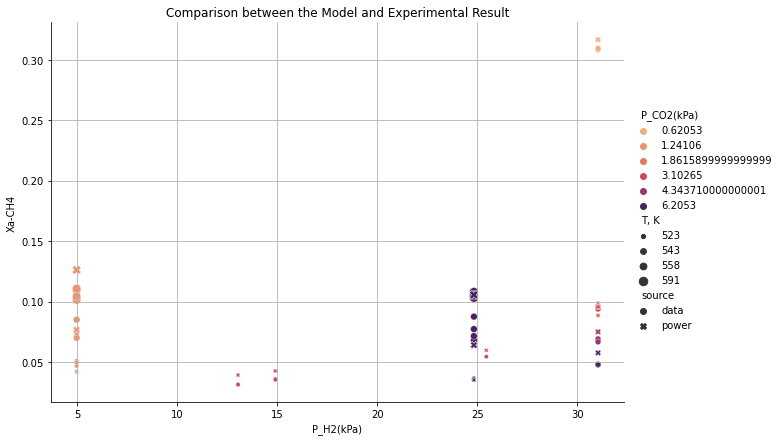

In [31]:
a = sns.relplot(data=dff,x='P_H2(kPa)',y='Xa-CH4',hue='P_CO2(kPa)',
                size='T, K',style='source', palette='flare',aspect=12/8,height=6)
#a.axes[0,0].set_ylim(0,1); 
a.set(title='Comparison between the Model and Experimental Result')
plt.grid()
plt.show()

In [43]:
#rsquared value
seni = (dff[dff['source']=='power']['Xa-CH4'] - dff[dff['source']=='data']['Xa-CH4'])**2
ssa = (dff[dff['source']=='data']['Xa-CH4'] - dff[dff['source']=='data']['Xa-CH4'].mean())**2
rsquared = 1-seni.sum()/ssa.sum(); rsquared

0.9804172916022056

In [49]:
#MAPE - mean absolute percent error
abe = np.abs((dff[dff['source']=='power']['Xa-CH4'] - dff[dff['source']=='data']['Xa-CH4'])/dff[dff['source']=='data']['Xa-CH4'])
abe.mean()*100

9.820695068453018

### Discussion

In [90]:
res.x

array([5.55558986e-01, 4.15282678e+04, 6.29634708e-01, 2.59626376e-01])

The values regressed from the data differ significantly from those reported by Bartholomew
<table>
        <tr>
        <td> Source </td><td>A</td><td>Ea, kJ/mol</td><td>m</td><td>n</td>
            </tr>
    <tr>
        <td> Bartholomew </td><td>1.56E5</td><td>89</td><td>0.35 (H2)</td><td>0.2 (CO2)</td>
    </tr>
    <tr>
        <td> This Data - GC 1 </td><td>71.49</td><td>57</td><td>-0.24 (H2)</td><td>1.01 (CO2)</td>
    </tr>
    <tr>
        <td> This Data - GC 2 </td><td>9.55</td><td>40</td><td>-1.6 (H2)</td><td>2.6 (CO2)</td>
    </tr>    
</table>

## Scaleup Recommendation

Scale up to 10E4 SLM flow (4% CO2, 20% H2, and inerts). Since most of the data was taken with a conversion of less than 30%, the scale-up will be limited to that.



What is the increase in heating rates versus just burning the input (as 20% H2 is the input)

Should the process go forward or should the stream just be burned?

Rate at 270 C (543 K), 1 atm, 10,000 SLM, 4% CO2, 20% H2

In [29]:
molarflow = 1e4/1e3*101325/(Rg*298)/60 #SLM to mol/second
pressure = 101.325 #1 atm to kPa

In [30]:
def func(x,*input):
    dct = input[0]
    rate = res.x[0]*np.exp(-res.x[1]/8.314/543)*(4*0.04*(1-x)*pressure)**res.x[2]*(0.04*(1-x)*pressure)**res.x[3]
    #rate = 1.56E5*np.exp(-89000/8.314/543)*(4*0.04*(1-x)*pressure)**0.35*(0.04*(1-x)*pressure)**0.2
    zero2rd = x - rate*dct['weight']/molarflow
    return zero2rd

In [31]:
def conversions(weight):
    input = {'weight':weight}
    return fsolve(func,0.3,args=(input))

In [32]:
conversions(1000)

array([0.06455851])

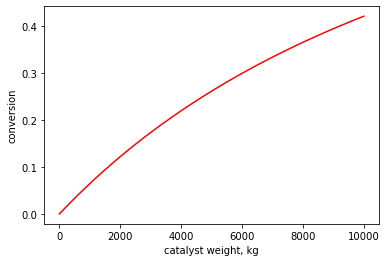

In [33]:
wlin = np.linspace(0, 10000, 100)
xalin = [conversions(each) for each in wlin]
plt.plot(wlin, xalin, 'r', label='fitted line'); 
plt.xlabel("catalyst weight, kg"); plt.ylabel("conversion")
plt.show()

In [34]:
molarflow*0.04*conversions(1000)*0.016*2.205*60*60*24 #lb/sec

array([53.65311015])

In [35]:
#conversion mean from the data
dfh.Xa.mean()

NameError: name 'dfh' is not defined

## Appendix: Groupby Option

In [ ]:
binsH2 = [0,14,22,30]
PH2names=['10','18','26']
binsCO2=[0,3,5,10]
PCO2names=['2','4','6']
dfh['PH2bins']=pd.cut(dfh['P_H2(kPa)'],binsH2,labels=PH2names)
dfh['PCO2bins']=pd.cut(dfh['P_CO2(kPa)'],binsCO2,labels=PCO2names)

In [ ]:
grouped = dfh.groupby(['T(K)','PH2bins','PCO2bins'])['rate (mol/kg/s)'].mean().to_frame(name='rate (mol/kg/s)').reset_index()

In [ ]:
grouped = grouped.dropna()

In [ ]:
grouped.PH2bins = pd.to_numeric(grouped.PH2bins)
grouped.PCO2bins = pd.to_numeric(grouped.PCO2bins)

In [ ]:
grouped.groupby(['PH2bins'])['rate (mol/kg/s)'].plot()

In [ ]:
a = sns.relplot(data=grouped,x='PCO2bins',y='rate (mol/kg/s)',hue='PH2bins',
                size='T(K)', palette='flare',aspect=12/8,height=6)
#a.axes[0,0].set_ylim(0,40); 
a.set(title='Comparison between the Model and Experimental Result')
plt.grid()
plt.show()